In [40]:
import numpy as np
import networkx as nx
import random

snapshot_size_dict = {'uci': 4000, 'digg': 6000, 'email-dnc':3000, 'as-topology': 8000, 'btc-alpha': 2000, 'btc-otc': 2000, 'ai-patent': 8000, 'nci-project': 8000}


In [41]:
def read_data_file(dataset):
    print('Reading files...')
    nodes = [] # list of node ids
    edges = [] # list of edge tuples with (head, tail, weight, timestamp)
    with open('../dataset/raw/'+dataset, 'r') as f:
        lines = f.readlines()
    content = lines[2:]
    for line in content:
        tmp = line.strip().split(' ')
        if int(tmp[0]) not in nodes:
            nodes.append(int(tmp[0]))
        if int(tmp[1]) not in nodes:
            nodes.append(int(tmp[1]))
        edges.append((int(tmp[0]), int(tmp[1]), int(tmp[2]), int(tmp[3])))
    return nodes, edges

In [42]:
def split_graph_by_size(nodes, edges, dataset_name):
    print('Generating snapshots...')
    dtype = [('head', int),('tail', int),('weight', int), ('time',int)]
    edges = np.array(edges, dtype=dtype)
    edges = list(np.sort(edges, order='time'))
    snapshots = []
    count = 0
    G = nx.MultiGraph()
    G.add_nodes_from(nodes)
    for edge in edges:
        if count < snapshot_size_dict[dataset_name]:
            G.add_edge(edge[0], edge[1], weight=edge[2])
            count += 1
        else:
            count = 0
            snapshots.append(G)
            G = nx.MultiGraph()
            G.add_nodes_from(nodes)
    return snapshots

In [43]:
def negative_node_pair_sampling(snapshots, sample_size):
    nodes_current = [n for n in snapshots[-1].nodes]
    node_pairs = []
    while(1):
        candidate = random.sample(nodes_current, 2)
        for i in range(len(snapshots)):
            if snapshots[i].has_edge(candidate[0], candidate[1]):
                break
            else:
                continue
        if i == len(snapshots) - 1 and candidate not in node_pairs:
            node_pairs.append(candidate)
        if len(node_pairs) == sample_size:
            break
    return node_pairs

In [128]:
def get_feature_dc(dataset):
    time_window_len = 4
    nodes, edges = read_data_file(dataset)
    snapshots = split_graph_by_size(nodes, edges, dataset)
    snapshots_train = snapshots[:time_window_len]
    snapshots_test = snapshots[-time_window_len:]
    edges_current = [[e[0], e[1]] for e in snapshots[-1].edges]  # sample target edges from current timestamp
    target_edges_normal = random.sample(edges_current, round(len(edges_current) * 0.1))
    target_edges_anomaly = negative_node_pair_sampling(snapshots, len(target_edges_normal))
    
    feature_normal = []
    for edge in target_edges_normal:
        node1 = edge[0]
        node2 = edge[1]
        try:
            distance_prev = nx.shortest_path_length(snapshots[-2], source=node1, target=node2)
        except nx.NetworkXNoPath:
            distance_prev = random.randint(5,10)
        feature_normal.append(distance_prev + random.random())
    feature_anomaly = []
    for edge in target_edges_anomaly:
        node1 = edge[0]
        node2 = edge[1]
        try:
            distance_prev = nx.shortest_path_length(snapshots[-2], source=node1, target=node2)
        except nx.NetworkXNoPath:
            distance_prev = random.randint(6,10)
        feature_anomaly.append(distance_prev + random.random())
    return feature_normal, feature_anomaly

In [129]:
fn1, fa1 = get_feature_dc('uci')
fn2, fa2 = get_feature_dc('digg')
fn3, fa3 = get_feature_dc('email-dnc')
fn4, fa4 = get_feature_dc('btc-alpha')
fn5, fa5 = get_feature_dc('btc-otc')
fn6, fa6 = get_feature_dc('as-topology')

Reading files...
Generating snapshots...
Reading files...
Generating snapshots...
Reading files...
Generating snapshots...
Reading files...
Generating snapshots...
Reading files...
Generating snapshots...
Reading files...
Generating snapshots...


In [130]:
import numpy as np
import matplotlib.pyplot as plt

y11 = fn1 + fa1
x11 = [random.random() for i in range(len(fn1) + len(fa1))]
colors11 = ['#3A5FCD']*len(fn1) + ['#EE4000']*len(fa1)

y12 = fn2 + fa2
x12 = [random.random() for i in range(len(fn2) + len(fa2))]
colors12 = ['#3A5FCD']*len(fn2) + ['#EE4000']*len(fa2)

y13 = fn3 + fa3
x13 = [random.random() for i in range(len(fn3) + len(fa3))]
colors13 = ['#3A5FCD']*len(fn3) + ['#EE4000']*len(fa3)

y14 = fn4 + fa4
x14 = [random.random() for i in range(len(fn4) + len(fa4))]
colors14 = ['#3A5FCD']*len(fn4) + ['#EE4000']*len(fa4)

y15 = fn5 + fa5
x15 = [random.random() for i in range(len(fn5) + len(fa5))]
colors15 = ['#3A5FCD']*len(fn5) + ['#EE4000']*len(fa5)

y16 = fn6 + fa6
x16 = [random.random() for i in range(len(fn6) + len(fa6))]
colors16 = ['#3A5FCD']*len(fn6) + ['#EE4000']*len(fa6)
area = 5


In [131]:
def get_feature_ic(dataset):
    time_window_len = 4
    nodes, edges = read_data_file(dataset)
    snapshots = split_graph_by_size(nodes, edges, dataset)
    snapshots_train = snapshots[:time_window_len]
    snapshots_test = snapshots[-time_window_len:]
    edges_current = [[e[0], e[1]] for e in snapshots[-1].edges]  # sample target edges from current timestamp
    target_edges_normal = random.sample(edges_current, round(len(edges_current) * 0.1))
    target_edges_anomaly = negative_node_pair_sampling(snapshots, len(target_edges_normal))
    
    interact_normal = []
    for edge in target_edges_normal:
        node1 = edge[0]
        node2 = edge[1]
        interact1 = snapshots[-2].degree(node1) + snapshots[-2].degree(node2)
        interact2 = snapshots[-1].degree(node1) + snapshots[-1].degree(node2)
        interact_score = abs(interact1 - interact2)
        interact_normal.append(interact_score)
    interact_anomaly = []
    for edge in target_edges_anomaly:
        node1 = edge[0]
        node2 = edge[1]
        interact1 = snapshots[-2].degree(node1) + snapshots[-2].degree(node2)
        interact2 = snapshots[-1].degree(node1) + snapshots[-1].degree(node2)
        interact_score = abs(interact1 - interact2)
        interact_anomaly.append(interact_score)
    return interact_normal, interact_anomaly

In [132]:
fn1, fa1 = get_feature_ic('uci')
fn2, fa2 = get_feature_ic('digg')
fn3, fa3 = get_feature_ic('email-dnc')
fn4, fa4 = get_feature_ic('btc-alpha')
fn5, fa5 = get_feature_ic('btc-otc')
fn6, fa6 = get_feature_ic('as-topology')

Reading files...
Generating snapshots...
Reading files...
Generating snapshots...
Reading files...
Generating snapshots...
Reading files...
Generating snapshots...
Reading files...
Generating snapshots...
Reading files...
Generating snapshots...


In [133]:
import numpy as np
import matplotlib.pyplot as plt

y21 = fn1 + fa1
x21 = [random.random() for i in range(len(fn1) + len(fa1))]
colors21 = ['#3A5FCD']*len(fn1) + ['#EE4000']*len(fa1)

y22 = fn2 + fa2
x22 = [random.random() for i in range(len(fn2) + len(fa2))]
colors22 = ['#3A5FCD']*len(fn2) + ['#EE4000']*len(fa2)

y23 = fn3 + fa3
x23 = [random.random() for i in range(len(fn3) + len(fa3))]
colors23 = ['#3A5FCD']*len(fn3) + ['#EE4000']*len(fa3)

y24 = fn4 + fa4
x24 = [random.random() for i in range(len(fn4) + len(fa4))]
colors24 = ['#3A5FCD']*len(fn4) + ['#EE4000']*len(fa4)

y25 = fn5 + fa5
x25 = [random.random() for i in range(len(fn5) + len(fa5))]
colors25 = ['#3A5FCD']*len(fn5) + ['#EE4000']*len(fa5)

y26 = fn6 + fa6
x26 = [random.random() for i in range(len(fn6) + len(fa6))]
colors26 = ['#3A5FCD']*len(fn6) + ['#EE4000']*len(fa6)
area = 5

In [148]:
def get_feature_nc(dataset):
    time_window_len = 4
    nodes, edges = read_data_file(dataset)
    snapshots = split_graph_by_size(nodes, edges, dataset)
    snapshots_train = snapshots[:time_window_len]
    snapshots_test = snapshots[-time_window_len:]
    edges_current = [[e[0], e[1]] for e in snapshots[-1].edges]  # sample target edges from current timestamp
    target_edges_normal = random.sample(edges_current, round(len(edges_current) * 0.1))
    target_edges_anomaly = negative_node_pair_sampling(snapshots, len(target_edges_normal))
    
    common_normal = []
    for edge in target_edges_normal:
        node1 = edge[0]
        node2 = edge[1]
        neighbor11 = [n for n in snapshots[-2].neighbors(node1)]
        neighbor12 = [n for n in snapshots[-2].neighbors(node2)]
        common1 = len(list(set(neighbor11) & set(neighbor12)))
        neighbor21 = [n for n in snapshots[-1].neighbors(node1)]
        neighbor22 = [n for n in snapshots[-1].neighbors(node2)]
        common2 = len(list(set(neighbor21) & set(neighbor22)))
        common_score = abs(common2 - common1)
        common_normal.append(common_score + random.random())
    common_anomaly = []
    for edge in target_edges_anomaly:
        node1 = edge[0]
        node2 = edge[1]
        neighbor11 = [n for n in snapshots[-2].neighbors(node1)]
        neighbor12 = [n for n in snapshots[-2].neighbors(node2)]
        common1 = len(list(set(neighbor11) & set(neighbor12)))
        neighbor21 = [n for n in snapshots[-1].neighbors(node1)]
        neighbor22 = [n for n in snapshots[-1].neighbors(node2)]
        common2 = len(list(set(neighbor21) & set(neighbor22)))
        common_score = abs(common2 - common1)
        common_anomaly.append(common_score + random.random())
    return common_normal, common_anomaly

In [149]:
fn1, fa1 = get_feature_nc('uci')
fn2, fa2 = get_feature_nc('digg')
fn3, fa3 = get_feature_nc('email-dnc')
fn4, fa4 = get_feature_nc('btc-alpha')
fn5, fa5 = get_feature_nc('btc-otc')
fn6, fa6 = get_feature_nc('as-topology')

Reading files...
Generating snapshots...
Reading files...
Generating snapshots...
Reading files...
Generating snapshots...
Reading files...
Generating snapshots...
Reading files...
Generating snapshots...
Reading files...
Generating snapshots...


In [150]:
import numpy as np
import matplotlib.pyplot as plt

y31 = fn1 + fa1
x31 = [random.random() for i in range(len(fn1) + len(fa1))]
colors31 = ['#3A5FCD']*len(fn1) + ['#EE4000']*len(fa1)

y32 = fn2 + fa2
x32 = [random.random() for i in range(len(fn2) + len(fa2))]
colors32 = ['#3A5FCD']*len(fn2) + ['#EE4000']*len(fa2)

y33 = fn3 + fa3
x33 = [random.random() for i in range(len(fn3) + len(fa3))]
colors33 = ['#3A5FCD']*len(fn3) + ['#EE4000']*len(fa3)

y34 = fn4 + fa4
x34 = [random.random() for i in range(len(fn4) + len(fa4))]
colors34 = ['#3A5FCD']*len(fn4) + ['#EE4000']*len(fa4)

y35 = fn5 + fa5
x35 = [random.random() for i in range(len(fn5) + len(fa5))]
colors35 = ['#3A5FCD']*len(fn5) + ['#EE4000']*len(fa5)

y36 = fn6 + fa6
x36 = [random.random() for i in range(len(fn6) + len(fa6))]
colors36 = ['#3A5FCD']*len(fn6) + ['#EE4000']*len(fa6)
area = 5

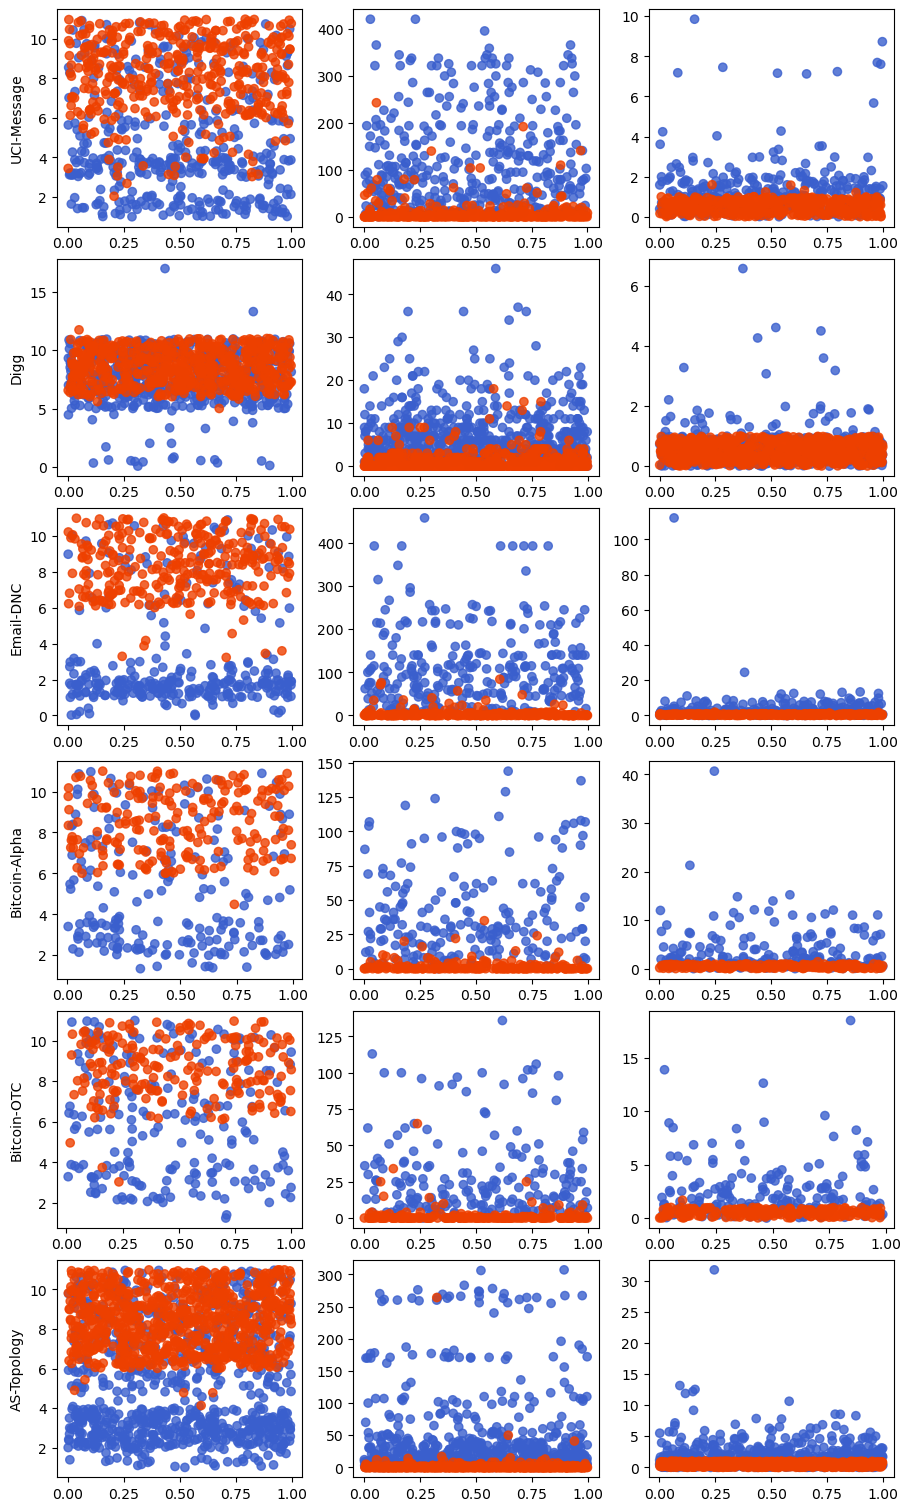

In [151]:
fig, axs = plt.subplots(nrows=6, ncols=3, constrained_layout=True, figsize=(9,15))

axs[0][0].scatter(x11,y11, c=colors11,alpha=0.8)
axs[0][0].set_ylabel('UCI-Message')
axs[1][0].scatter(x12,y12, c=colors12,alpha=0.8)
axs[1][0].set_ylabel('Digg')
axs[2][0].scatter(x13,y13, c=colors13,alpha=0.8)
axs[2][0].set_ylabel('Email-DNC')
axs[3][0].scatter(x14,y14, c=colors14,alpha=0.8)
axs[3][0].set_ylabel('Bitcoin-Alpha')
axs[4][0].scatter(x15,y15, c=colors15,alpha=0.8)
axs[4][0].set_ylabel('Bitcoin-OTC')
axs[5][0].scatter(x16,y16, c=colors16,alpha=0.8)
axs[5][0].set_ylabel('AS-Topology')
axs[0][1].scatter(x21,y21, c=colors21,alpha=0.8)
axs[1][1].scatter(x22,y22, c=colors22,alpha=0.8)
axs[2][1].scatter(x23,y23, c=colors23,alpha=0.8)
axs[3][1].scatter(x24,y24, c=colors24,alpha=0.8)
axs[4][1].scatter(x25,y25, c=colors25,alpha=0.8)
axs[5][1].scatter(x26,y26, c=colors26,alpha=0.8)
axs[0][2].scatter(x31,y31, c=colors31,alpha=0.8)
axs[1][2].scatter(x32,y32, c=colors32,alpha=0.8)
axs[2][2].scatter(x33,y33, c=colors33,alpha=0.8)
axs[3][2].scatter(x34,y34, c=colors34,alpha=0.8)
axs[4][2].scatter(x35,y35, c=colors35,alpha=0.8)
axs[5][2].scatter(x36,y36, c=colors36,alpha=0.8)
plt.savefig('./pics/anomaly_features.png')
plt.show()

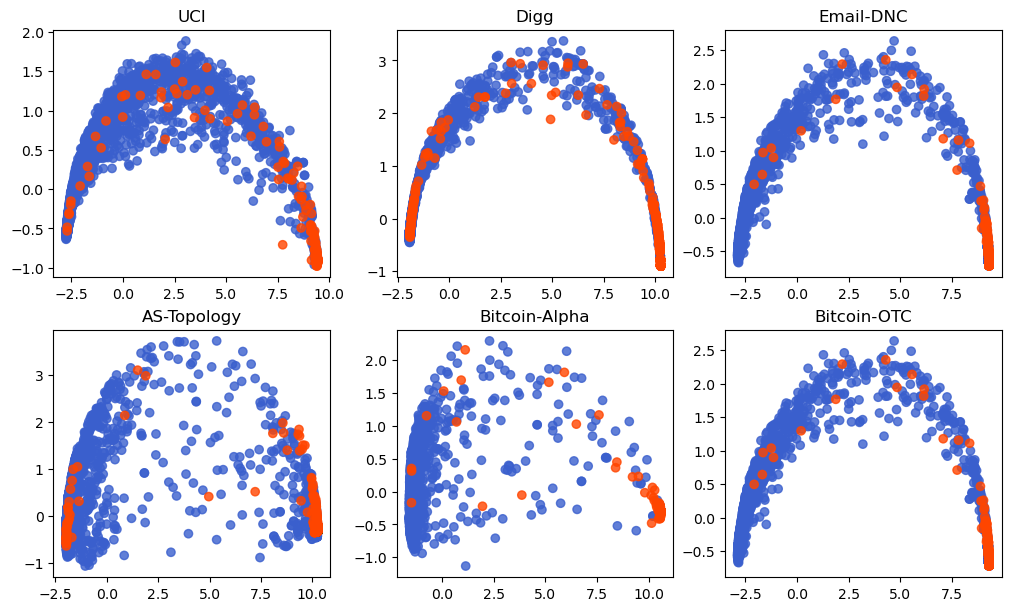

In [123]:
import matplotlib.pyplot as plt
# plot embedding scatter for each dataset
with open('./embs/output_all_uci', 'r') as f:
    emb1 = f.read()
    emb1 = eval(emb1)
x1 = [item[0] for item in emb1]
y1 = [item[1] for item in emb1]
with open('./embs/output_all_digg', 'r') as f:
    emb2 = f.read()
    emb2 = eval(emb2)
x2 = [item[0] for item in emb2]
y2 = [item[1] for item in emb2]
with open('./embs/output_all_email-dnc', 'r') as f:
    emb3 = f.read()
    emb3 = eval(emb3)
x3 = [item[0] for item in emb3]
y3 = [item[1] for item in emb3]
with open('./embs/output_all_as-topology', 'r') as f:
    emb4 = f.read()
    emb4 = eval(emb4)
x4 = [item[0] for item in emb4]
y4 = [item[1] for item in emb4]
with open('./embs/output_all_btc-alpha', 'r') as f:
    emb5 = f.read()
    emb5 = eval(emb5)
x5 = [item[0] for item in emb5]
y5 = [item[1] for item in emb5]
with open('./embs/output_all_btc-otc', 'r') as f:
    emb6 = f.read()
    emb6 = eval(emb6)
x6 = [item[0] for item in emb6]
y6 = [item[1] for item in emb6]

with open('./embs/label_uci', 'r') as f:
    label1 = f.read()
    label1 = eval(label1)
color1 = []
for item in label1:
    if item==0:
        color1.append('#3A5FCD')
    else:
        color1.append('#FF4500')
with open('./embs/label_digg', 'r') as f:
    label2 = f.read()
    label2 = eval(label2)
color2 = []
for item in label2:
    if item==0:
        color2.append('#3A5FCD')
    else:
        color2.append('#FF4500')
with open('./embs/label_email-dnc', 'r') as f:
    label3 = f.read()
    label3 = eval(label3)
color3 = []
for item in label3:
    if item==0:
        color3.append('#3A5FCD')
    else:
        color3.append('#FF4500')
with open('./embs/label_as-topology', 'r') as f:
    label4 = f.read()
    label4 = eval(label4)
color4 = []
for item in label4:
    if item==0:
        color4.append('#3A5FCD')
    else:
        color4.append('#FF4500')
with open('./embs/label_btc-alpha', 'r') as f:
    label5 = f.read()
    label5 = eval(label5)
color5 = []
for item in label5:
    if item==0:
        color5.append('#3A5FCD')
    else:
        color5.append('#FF4500')
with open('./embs/label_btc-otc', 'r') as f:
    label6 = f.read()
    label6 = eval(label6)
color6 = []
for item in label6:
    if item==0:
        color6.append('#3A5FCD')
    else:
        color6.append('#FF4500')
        
fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True, figsize=(10,6))

axs[0][0].scatter(x1,y1, c=color1,alpha=0.8)
axs[0][0].set_title('UCI')
axs[0][1].scatter(x2,y2, c=color2,alpha=0.8)
axs[0][1].set_title('Digg')
axs[0][2].scatter(x3,y3, c=color3,alpha=0.8)
axs[0][2].set_title('Email-DNC')
axs[1][0].scatter(x4,y4, c=color4,alpha=0.8)
axs[1][0].set_title('AS-Topology')
axs[1][1].scatter(x5,y5, c=color5,alpha=0.8)
axs[1][1].set_title('Bitcoin-Alpha')
axs[1][2].scatter(x3,y3, c=color3,alpha=0.8)
axs[1][2].set_title('Bitcoin-OTC')
plt.savefig('./pics/latent_visual.png')
plt.show()